In [1]:
%matplotlib notebook
%config Completer.use_jedi = False
import numpy as np
import freud
import lammps_reader as lammps
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
traj = lammps.lammpstraj.pandas_reader(fname='final.lammpstrj')

In [6]:
traj[1]

{1019300: array([[-10.50775   ,  10.50775   ],
        [-10.50775   ,  10.50775   ],
        [-39.86680013,  39.86680013]])}

In [7]:
box = traj[1][1019300]
frame = traj[0].loc[1019300]
box = freud.box.Box(box[0,1] - box[0,0],
                    box[1,1] - box[1,0],
                    box[2,1] - box[2,0])

In [8]:
frame

,type,x,y,z
id,,,,
215,2,-6.56366,-3.961150,-8.71724
411,1,-7.56270,-7.860830,-8.45359
83,2,-8.33359,-9.318440,-9.42595
521,1,-9.43572,-10.421800,-8.85894
410,2,-8.96270,-2.043650,-8.52450
...,...,...,...,...
90,2,3.45219,0.967687,8.99405
144,2,5.54536,6.805440,8.82053
460,2,2.20495,4.088380,7.90849


In [9]:
si = frame.loc[frame['type'] == 1]
o = frame.loc[frame['type'] == 2]

In [10]:
nlist = freud.locality.AABBQuery(box, frame.loc[:,['x','y','z']])

In [11]:
nlist.box

freud.box.Box(Lx=21.015499114990234, Ly=21.015499114990234, Lz=79.73359680175781, xy=0.0, xz=0.0, yz=0.0, is2D=False)

In [12]:
ngrid = 10
X,Y,Z = np.meshgrid(np.linspace(-11,11,ngrid), 
                    np.linspace(-11,11,ngrid), 
                    np.linspace(-11,11,ngrid))
x = X.flatten()
y = Y.flatten()
z = Z.flatten()
grid = np.vstack((np.vstack((x,y)),z)).T

In [13]:
localdens = freud.density.LocalDensity(8., 0)
silocal = freud.density.LocalDensity(6.2, 0)
olocal = freud.density.LocalDensity(6., 0)
rdf = freud.density.RDF(30,10)
ordf = freud.density.RDF(30,10)
sirdf = freud.density.RDF(30,10)

rdf.compute(nlist)
ordf.compute(system=(nlist.box, o.loc[:,['x','y','z']]), query_points=o.loc[:,['x','y','z']])
sirdf.compute(system=(nlist.box, si.loc[:,['x','y','z']]), query_points=si.loc[:,['x','y','z']])
localdens.compute(nlist)
silocal.compute(nlist, query_points=si.loc[:,['x','y','z']])
olocal.compute(nlist, query_points=o.loc[:,['x','y','z']])
ordf = ordf.rdf.copy()
ordf[0] = 0
sirdf = sirdf.rdf.copy()
sirdf[0] = 0

<IPython.core.display.Javascript object>


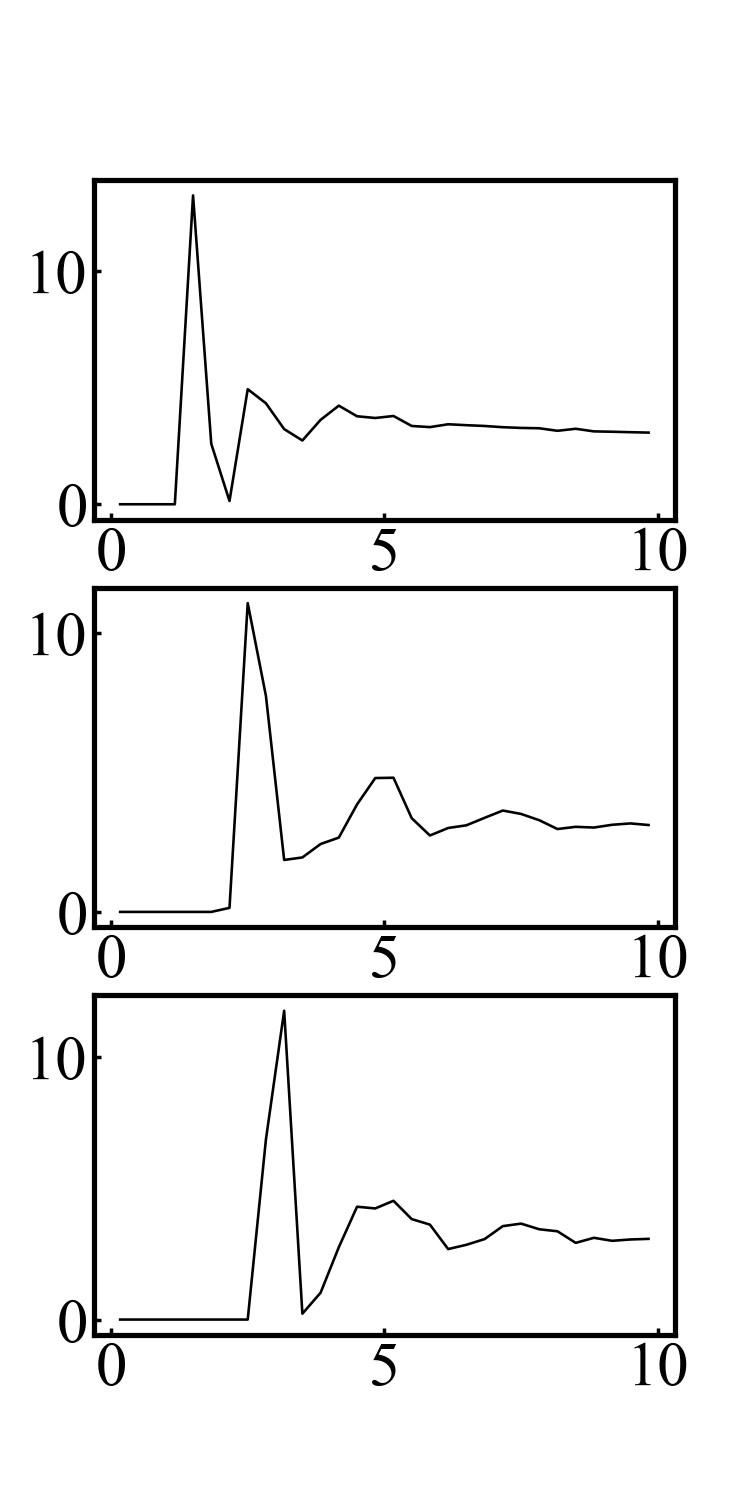

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(6,12))
ax[0].plot(rdf.bin_centers, rdf.rdf, '-k')
ax[1].plot(rdf.bin_centers, ordf, '-k')
ax[2].plot(rdf.bin_centers, sirdf, '-k')

In [15]:
ocutoff = 0.06
sicutoff = 0.057
cutoff = 0.055
surfaces = nlist.points[localdens.density < cutoff]
top_surf = surfaces[surfaces[:,2] > 0.0]
bottom_surf = surfaces[surfaces[:,2] < 0.0]

<IPython.core.display.Javascript object>


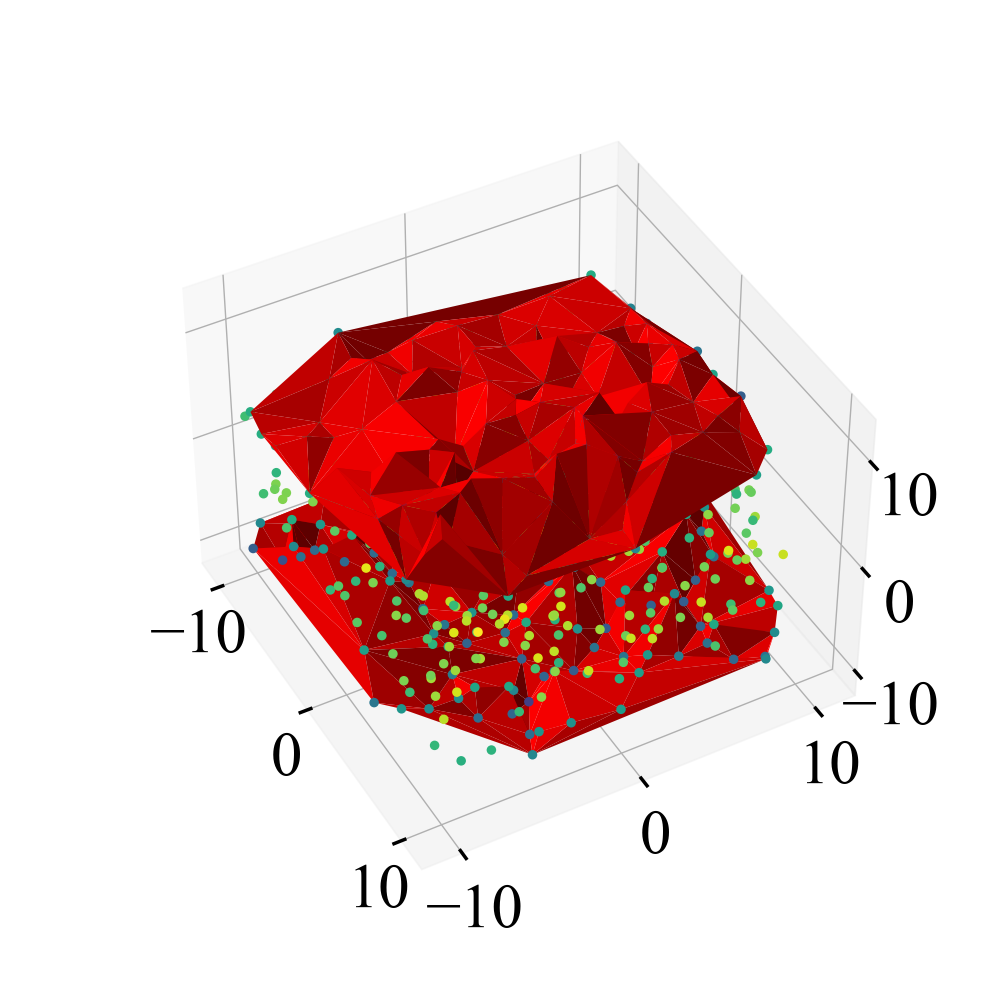

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(grid[:,0], grid[:,1], grid[:,2], c=localdens.density, depthshade=False)
ax.scatter(nlist.points[:,0], nlist.points[:,1], nlist.points[:,2], c=localdens.density,
          depthshade=False)
ax.plot_trisurf(top_surf[:,0],top_surf[:,1],top_surf[:,2],color='r')
ax.plot_trisurf(bottom_surf[:,0],bottom_surf[:,1],bottom_surf[:,2],color='r')

<IPython.core.display.Javascript object>


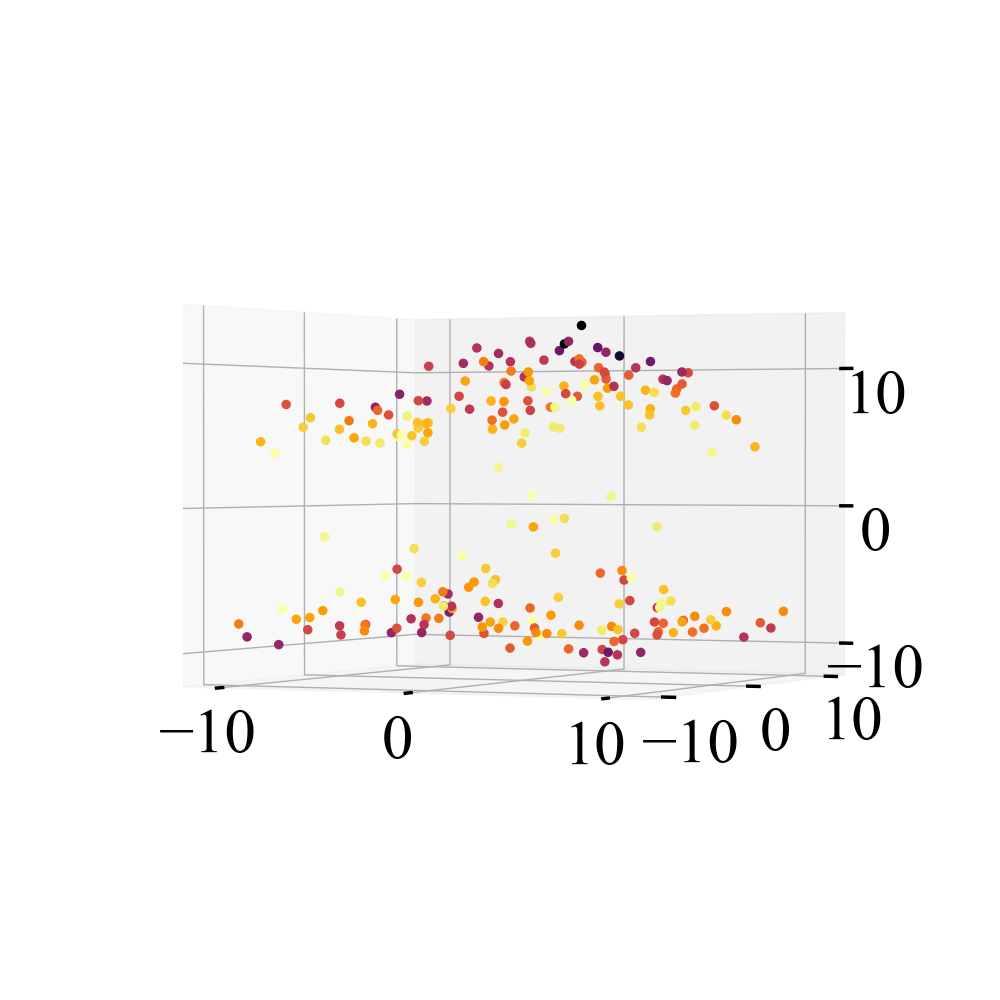

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(grid[:,0], grid[:,1], grid[:,2], c=localdens.density, depthshade=False)
ax.scatter(si.loc[silocal.density < sicutoff,'x'], 
           si.loc[silocal.density < sicutoff,'y'], 
           si.loc[silocal.density < sicutoff,'z'], 
           c=silocal.density[silocal.density < sicutoff], cmap='inferno',
          depthshade=False)
ax.scatter(o.loc[olocal.density < ocutoff,'x'], 
           o.loc[olocal.density < ocutoff,'y'], 
           o.loc[olocal.density < ocutoff,'z'], 
           c=olocal.density[olocal.density < ocutoff], cmap='inferno',
          depthshade=False)
#ax.plot_trisurf(top_surf[:,0],top_surf[:,1],top_surf[:,2],color='r')
#ax.plot_trisurf(bottom_surf[:,0],bottom_surf[:,1],bottom_surf[:,2],color='r')

<IPython.core.display.Javascript object>


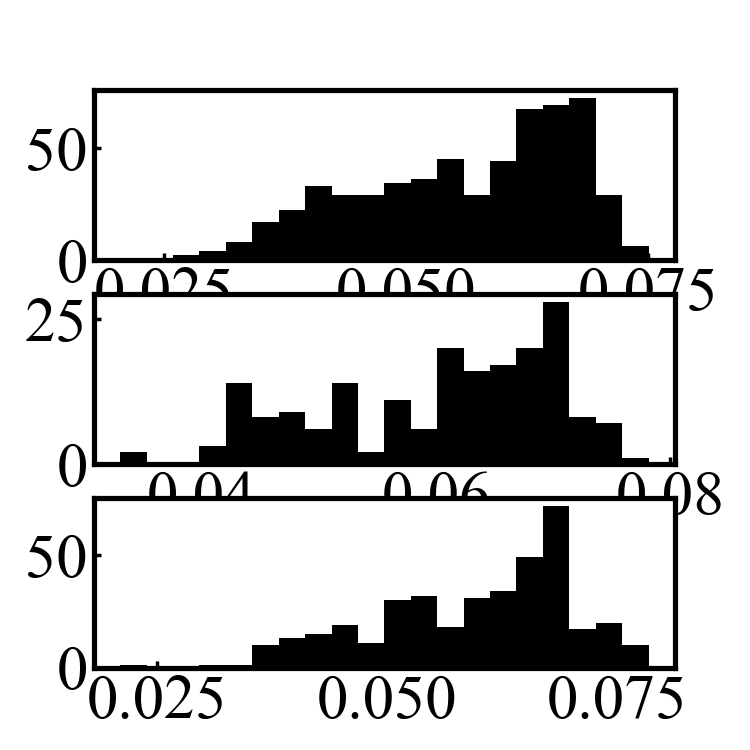

(array([ 1.,  0.,  0.,  1.,  1., 10., 13., 15., 19., 11., 30., 32., 18.,
        31., 34., 49., 72., 17., 20., 10.]),
 array([0.02099961, 0.02387324, 0.02674687, 0.0296205 , 0.03249414,
        0.03536776, 0.03824139, 0.04111503, 0.04398866, 0.04686229,
        0.04973592, 0.05260955, 0.05548318, 0.05835681, 0.06123044,
        0.06410407, 0.0669777 , 0.06985133, 0.07272497, 0.0755986 ,
        0.07847223], dtype=float32),
 <BarContainer object of 20 artists>)

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(6,6))
ax[0].hist(localdens.density, bins=20)
ax[1].hist(silocal.density, bins=20)
ax[2].hist(olocal.density, bins=20)